In [1]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
file_path = '/content/gdrive/MyDrive/Rathbun lab GDrive/Prof Rathbun/BRET efficiencies/Fluor spectra.xlsx'
df = pd.read_excel(file_path)
df

,wavelength,fluor-peptide,Trial 1,Trial 2,Trial 3
0,300,SmBiT,0.001638,0.001796,0.009700
1,305,SmBiT,0.005679,0.002984,0.017045
2,310,SmBiT,0.004382,0.000221,0.001203
3,315,SmBiT,0.001765,0.001741,0.002559
4,320,SmBiT,0.003722,0.002183,0.000486
...,...,...,...,...,...
239,580,TMR-SmBiT,0.775318,0.886821,0.952941
240,585,TMR-SmBiT,1.000000,0.961255,1.000000
241,590,TMR-SmBiT,0.940390,1.000000,0.957819
242,595,TMR-SmBiT,0.809511,0.920011,0.986657


In [3]:
df = pd.melt(df, id_vars=['wavelength', 'fluor-peptide'], var_name='Trial', value_name='Normalized emission')
df

,wavelength,fluor-peptide,Trial,Normalized emission
0,300,SmBiT,Trial 1,0.001638
1,305,SmBiT,Trial 1,0.005679
2,310,SmBiT,Trial 1,0.004382
3,315,SmBiT,Trial 1,0.001765
4,320,SmBiT,Trial 1,0.003722
...,...,...,...,...
727,580,TMR-SmBiT,Trial 3,0.952941
728,585,TMR-SmBiT,Trial 3,1.000000
729,590,TMR-SmBiT,Trial 3,0.957819
730,595,TMR-SmBiT,Trial 3,0.986657


<Axes: xlabel='wavelength', ylabel='Normalized emission'>

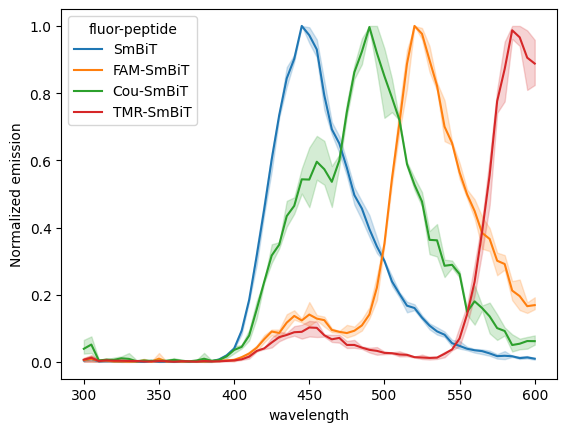

In [4]:
sns.lineplot(df, x='wavelength', y='Normalized emission', hue='fluor-peptide')

In [5]:
# plot as above with plotly
import plotly.express as px
fig = px.line(df, x='wavelength', y='Normalized emission', color='fluor-peptide', )
fig.show()

In [24]:
def extrapolate(df, x_col, y_col, start=-2, stop=None):
  df[y_col] = df[y_col].astype('float64')
  df[x_col] = df[x_col].astype('float64')

  # extrapolate the final point
  y = df[y_col][start:stop].values
  x = df[x_col][start:stop].values
  print(x,y)
  m, b = np.polyfit(x, y, 1)

  # find the x intercept
  x_intercept = -b/m
  extrap_y = m*x_intercept + b

  x = np.append(df[x_col].values, x_intercept)
  y = np.append(df[y_col].values, extrap_y)

  return x, y

from scipy.optimize import curve_fit

def gaussian(x, a, emission_max, width):
    return a * np.exp(-((x - emission_max)**2) / (2 * width**2))

def boltzmann(w, w_plus, w_minus, w_max, I_max): # from https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1751-1097.1996.tb02464.x
  v = 1/w
  v_plus = 1/w_plus
  v_minus = 1/w_minus
  v_max = 1/w_max
  H = v_plus - v_minus
  rho = (v_max - v_minus)/(v_plus - v_max)
  a = v_max + H*rho/(rho**2 - 1)
  I = I_max * np.exp(-(np.log(2)/np.log(rho)**2) * np.log((a - v)/(a - v_max))**2)
  # still need to implement. some of the math symbols are weird
  # if v < a:
  #   return I
  # else:
  #   return 0
  return np.where(v < a, I, 0)

def extrapolate_gaussian(df, x_col, y_col, cutoff, function=gaussian):
  # Drop rows with NaN in the y_col before converting to numpy arrays
  df = df.dropna(subset=[y_col]).copy()

  y_col = df[y_col].astype('float64').values
  x_col = df[x_col].astype('float64').values
  cutoff = list(x_col).index(cutoff)

  # fit to gaussian
  print("Fitting x,y: ",x_col[cutoff:], y_col[cutoff:])
  popt, pcov = curve_fit(function, x_col[cutoff:], y_col[cutoff:],
                         #p0=[1, 400, 50], # for gaussian
                         #bounds=([.1, 100, 1], [1.5, 1000, 500]), # for gaussian
                         p0=[10, 10, 550, 1], # for boltzmann
                         bounds=([1, 1, 1, 0.1], [100, 100, 1000, 1]), # for boltzmann
                         )
  #a, emission_max, width = popt
  print("Found params: ", popt)

  # add 20 more datapoints (100 nm worth)
  x_extrap = np.linspace(x_col[-1]+5, x_col[-1]+105, 20)
  y_extrap = function(x_extrap, *popt)

  x = np.append(x_col, x_extrap)
  y = np.append(y_col, y_extrap)

  return x, y, popt

def trapezoidal_int(x, y, cutoff):
  wavelength_index = list(x).index(cutoff)
  all = integrate.trapezoid(y, x)
  lgbit = integrate.trapezoid(y[:wavelength_index], x[:wavelength_index])
  bret = integrate.trapezoid(y[wavelength_index:], x[wavelength_index:])
  efficiency = bret/all
  print("Total: ",all)
  print("LG-bit: ",lgbit)
  print("BRET: ",bret)
  print("Efficiency: ",efficiency)
  print("Medintz Ratio: ", bret/lgbit)
  return all, lgbit, bret, efficiency

In [25]:
# compute the mean of the three trials
df_mean = df.groupby(['fluor-peptide', 'wavelength']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
#df_mean

Total:  83.28511196925452
LG-bit:  21.306649339672674
BRET:  59.20474757148746
Efficiency:  0.7108683193383164
Medintz Ratio:  2.778698171995025
Fitting x,y:  [525. 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585. 590.
 595. 600.] [0.97647672 0.89844333 0.82208796 0.70012564 0.65144918 0.56422333
 0.49867171 0.44915922 0.38405033 0.36599478 0.30110822 0.2914333
 0.21234546 0.19582587 0.16592649 0.16904011]


/tmp/ipython-input-24-2817899807.py:32: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipython-input-24-2817899807.py:33: RuntimeWarning:

invalid value encountered in log



ValueError: array must not contain infs or NaNs

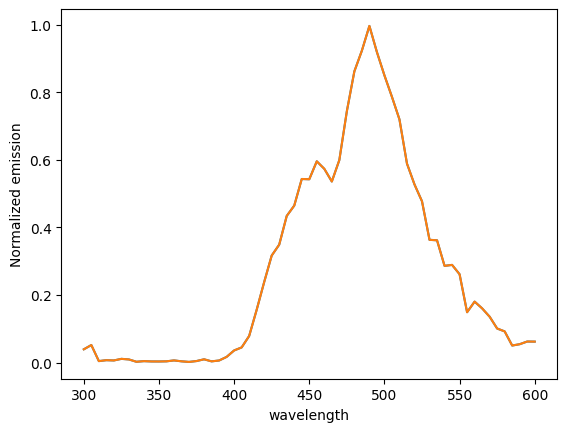

In [26]:
d = {
    'Peptide': [],
    'Total': [],
    'LG-bit': [],
    'BRET': [],
    'Efficiency': [],
    'Medintz Ratio': []
}

integration_cutoffs = {
    'SmBiT': 300,
    'FAM-SmBiT': 475,
    'TMR-SmBiT': 530,
    'Cou-SmBiT': 465,
}

fit_cutoffs = {
    'SmBiT': 300,
    #'FAM-SmBiT': 475,
    'FAM-SmBiT': 525,
    'TMR-SmBiT': 530,
    'Cou-SmBiT': 465,
}

should_extrapolate = {
    'SmBiT': False,
    'FAM-SmBiT': True,
    'TMR-SmBiT': True,
    'Cou-SmBiT': False,
}

for peptide in df_mean['fluor-peptide'].unique():
  df_temp = df_mean[(df_mean['fluor-peptide'] == peptide)]
  if should_extrapolate[peptide]:
    function = boltzmann
    x, y, popt = extrapolate_gaussian(df_temp, 'wavelength', 'Normalized emission', fit_cutoffs[peptide], function=function)
    y = function(x, *popt)
  else:
    x, y = df_temp['wavelength'].values, df_temp['Normalized emission'].values
  # plot the extrapolated data
  ax = sns.lineplot(x=x, y=y)
  sns.lineplot(df_temp, x='wavelength', y='Normalized emission', ax=ax)
  all, lgbit, bret, efficiency = trapezoidal_int(x, y, integration_cutoffs[peptide])
  d['Peptide'].append(peptide)
  d['Total'].append(all)
  d['LG-bit'].append(lgbit)
  d['BRET'].append(bret)
  d['Efficiency'].append(efficiency)
  d['Medintz Ratio'].append(bret/lgbit)

brets = pd.DataFrame(d)
brets